In [1]:
#stationary: AR
#trend: ARIMA
#seasonal: SARIMA
#variance correlated over time: ARCH
    #it models the next value from residual errors from a mean process (zero mean) (Engle 1982)
#modest change in variance: log or box-cox transform (stabilizes variance, make it more normal-like)
#change in variance over time: GARCH
    #Generalized autoregressive conditional heteroskedasticity (1986)
        #it incorporates a moving average (MA) to ARCH
    
    #p: The number of lag variances to include in the GARCH model.
    #q: The number of lag residual errors to include in the GARCH model.

    #a GARCH(0, q) = ARCH(q)
    #a GARCH(0, 0) = ARCH(0) = white noise
    
    #it is expected that data does not have a trend or seasonal component (that is, stationary) (how to ensure that?)

In [2]:
import inspect, pandas as pd, numpy as np
import matplotlib.pyplot as plt, matplotlib.ticker as ticker, seaborn as sns; sns.set()
from random import gauss, seed
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

1000


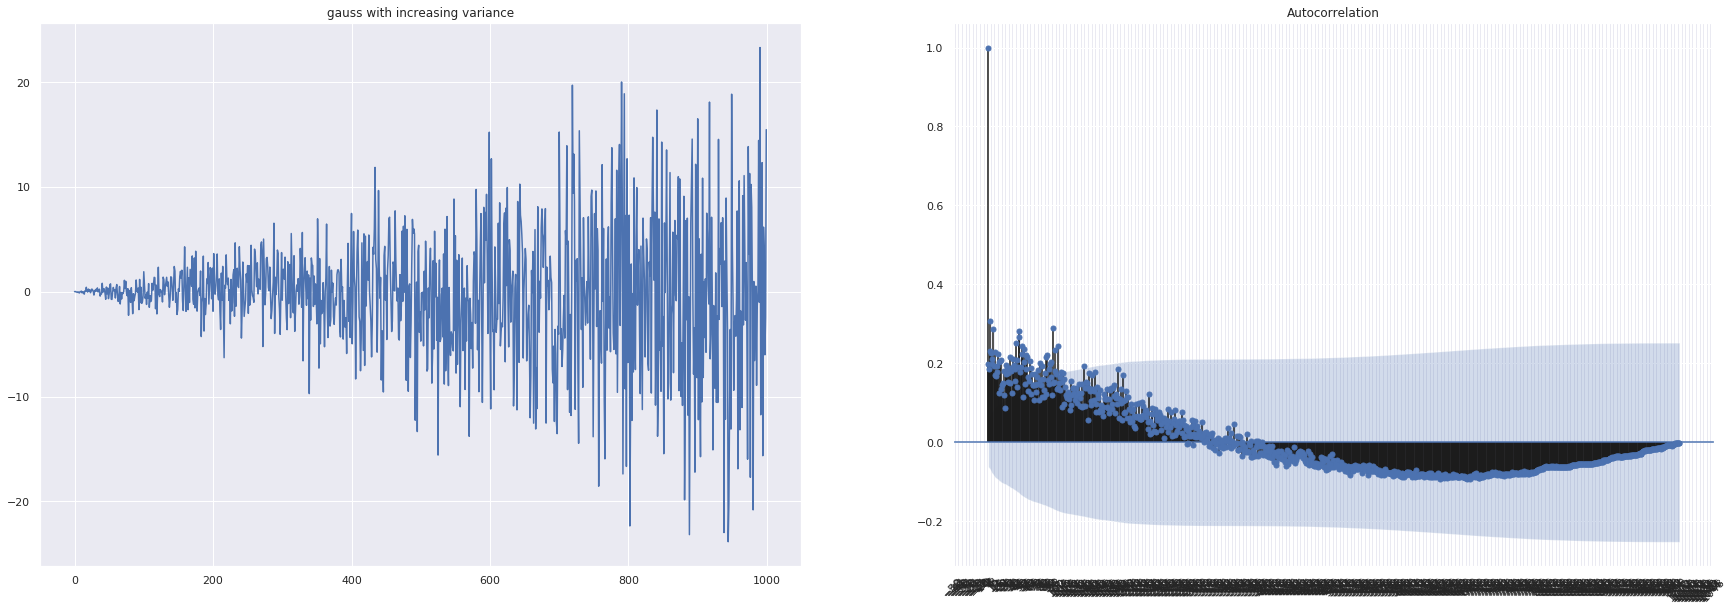

In [36]:
#print(inspect.getsource(gauss))
#gauss(mu, sigma)
seed(1)
data = [gauss(0, i*0.01) for i in np.arange(1000)+1]
print(len(data))
squared_data = [x**2 for x in data]
#***********
#* RESULTS *
#***********
fig, ax = plt.subplots(1, 2)
plt.gcf().set_size_inches(30, 10, forward=True)
ax[0].plot(data)
ax[0].set_title('gauss with increasing variance')
plot_acf(squared_data, ax=ax[1])
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(base=2))
ax[1].xaxis.set_tick_params(rotation=45)
plt.show()

In [ ]:
ntest=100
train,test = data[:-ntest], data[-ntest:]
model = arch_model(train, mean='Zero', vol='ARCH', p=15)
model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit()
yhat = model_fit.forecast(horizon=ntest, method='bootstrap')
#***********
#* RESULTS *
#***********
plt.gcf().set_size_inches(20, 10, forward=True)
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-ntest:])
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.legend(['actual variance', 'fit variance'])
plt.show()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2514.797655956599
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2513.419727121759
Iteration:      3,   Func. Count:     17,   Neg. LLF: 2424.6676672642798
Iteration:      4,   Func. Count:     29,   Neg. LLF: 2417.99764537149
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2413.328979822336
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2409.470461478144
Iteration:      7,   Func. Count:     47,   Neg. LLF: 2406.272116617404
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2403.6188792538205
Iteration:      9,   Func. Count:     59,   Neg. LLF: 2401.424169272062
Iteration:     10,   Func. Count:     65,   Neg. LLF: 2399.6253177954977
Iteration:     11,   Func. Count:     71,   Neg. LLF: 2398.176704995472
Iteration:     12,   Func. Count:     77,   Neg. LLF: 2396.963011082951
Iteration:     13,   Func. Count:     83,   Neg. LLF: 2395.5880086217803
Iteration:     14,   Func. Count:     88,   Neg. LLF: 2395.49

In [ ]:
model_fit.summary()

In [ ]:
#model_fit.plot()
#plt.show()
#seed(1)
e = np.sqrt(yhat.residual_variance.values[-1])#[gauss(0,1) for _ in np.arange(yhat.mean.shape[-1])]
mean, stddev = yhat.mean.values[-1], np.sqrt(yhat.variance.values[-1])
df = pd.DataFrame({'actual': data[-ntest:], 'predicted': mean + stddev*e})
df.plot()

In [ ]:
#************************************************************************************************
# http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016 *
#************************************************************************************************

In [29]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
print('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
print(sys.version)

Machine: Linux x86_64

3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]


In [30]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [31]:
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

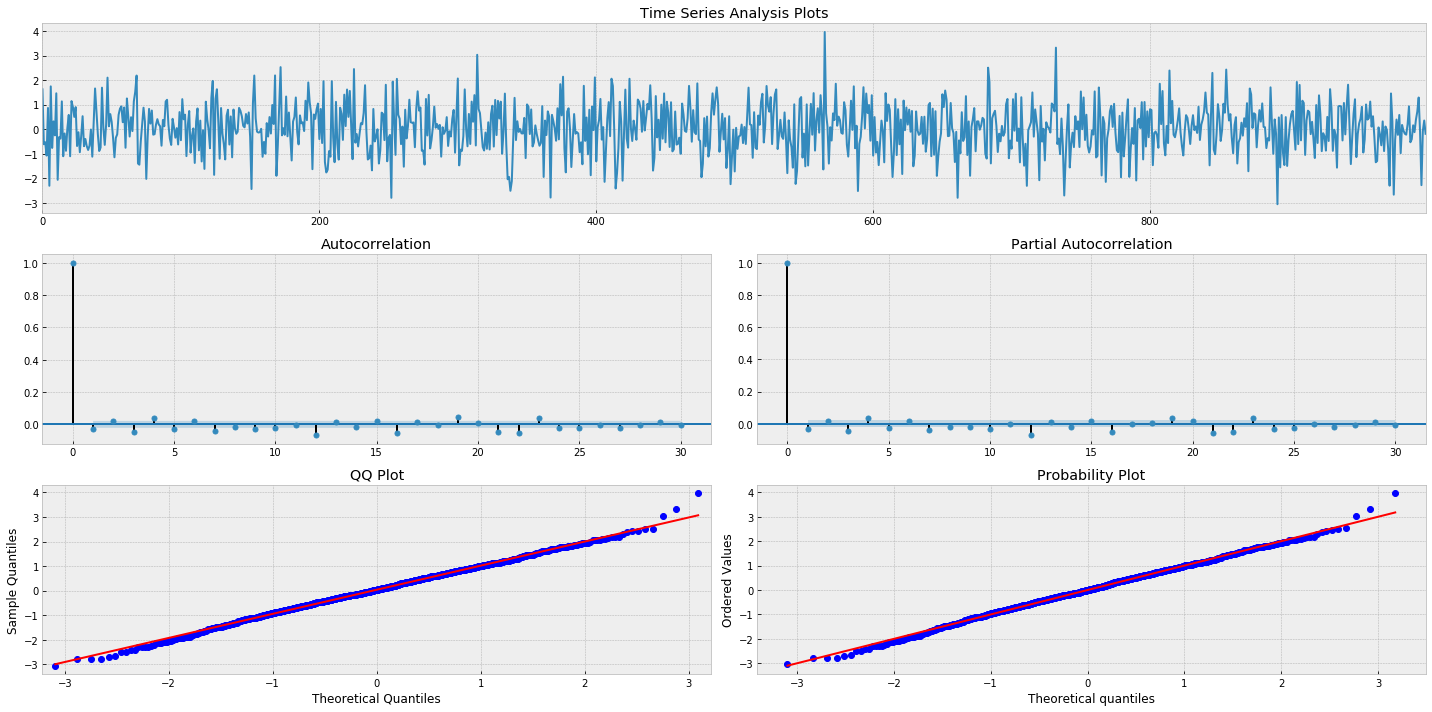

In [5]:
np.random.seed(1)
# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [47]:
print("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


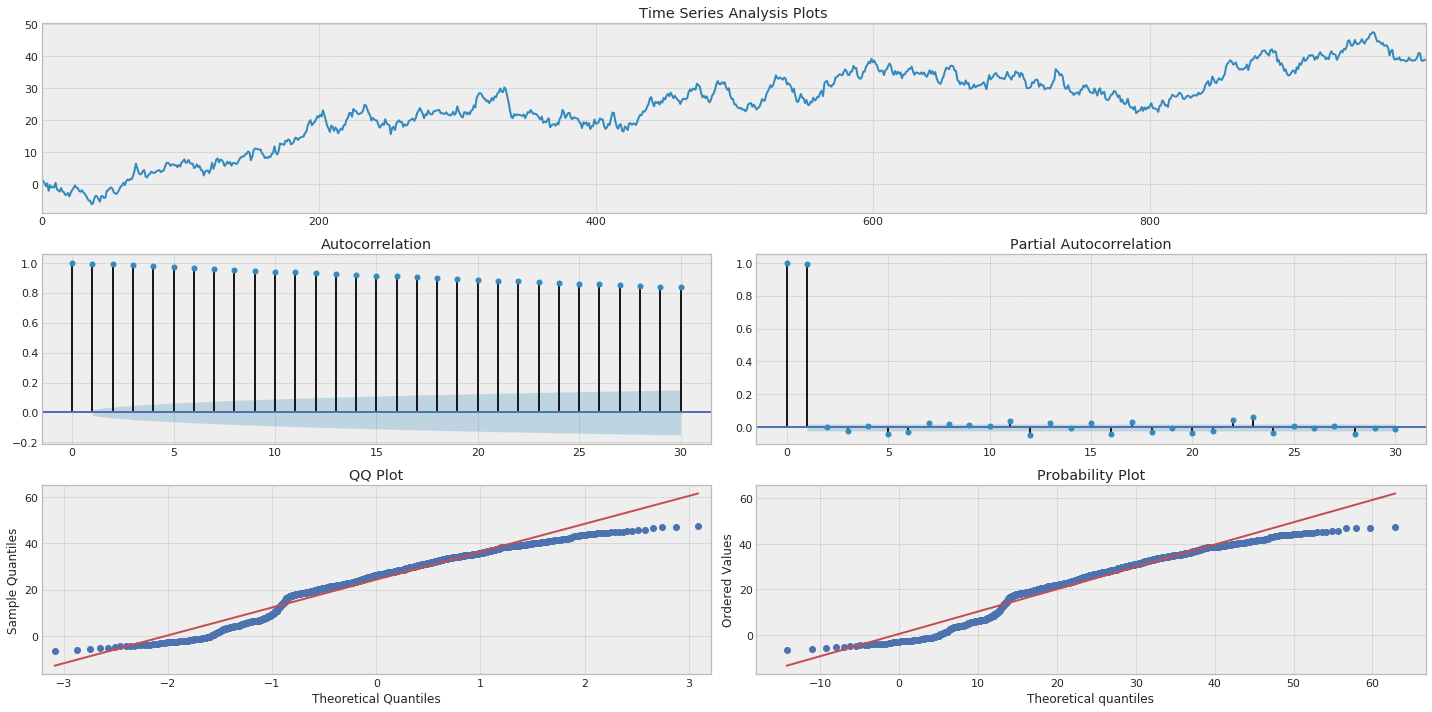

In [48]:
np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

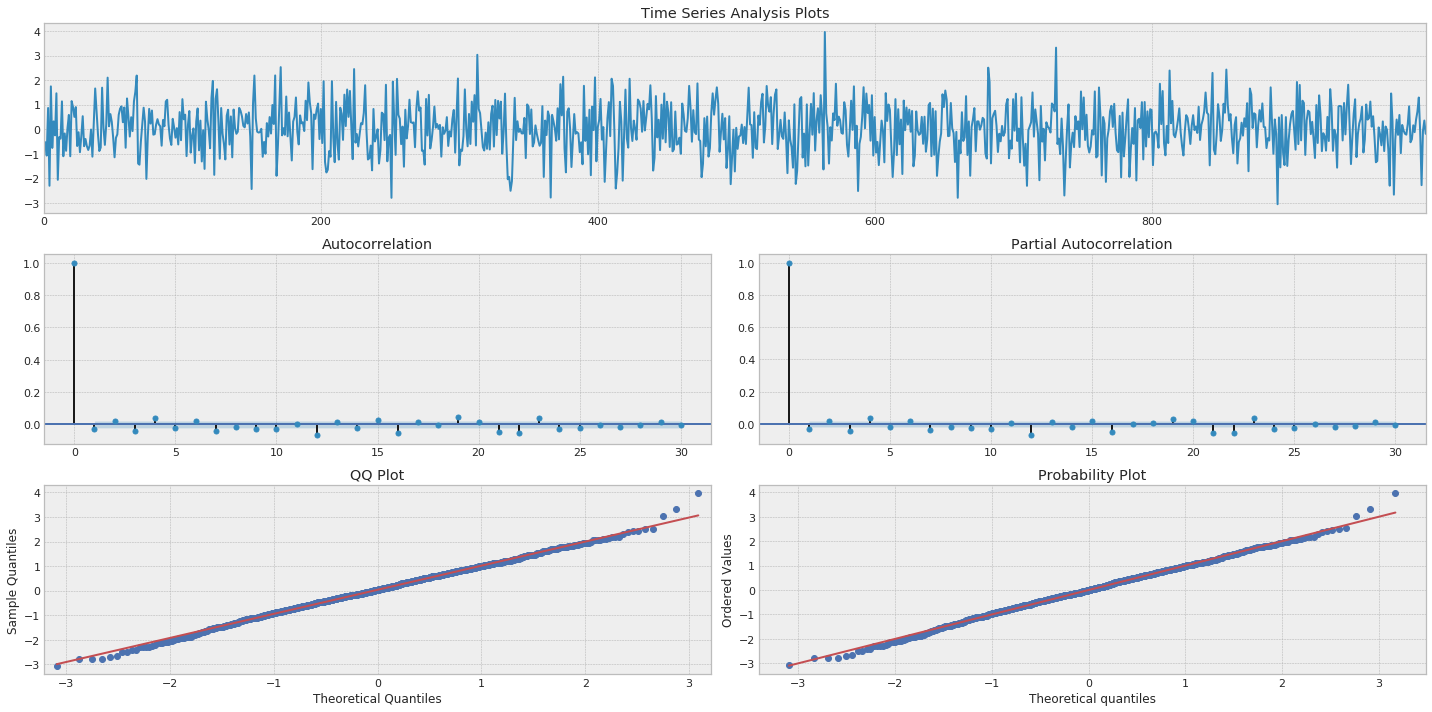

In [49]:
_ = tsplot(np.diff(x), lags=30)

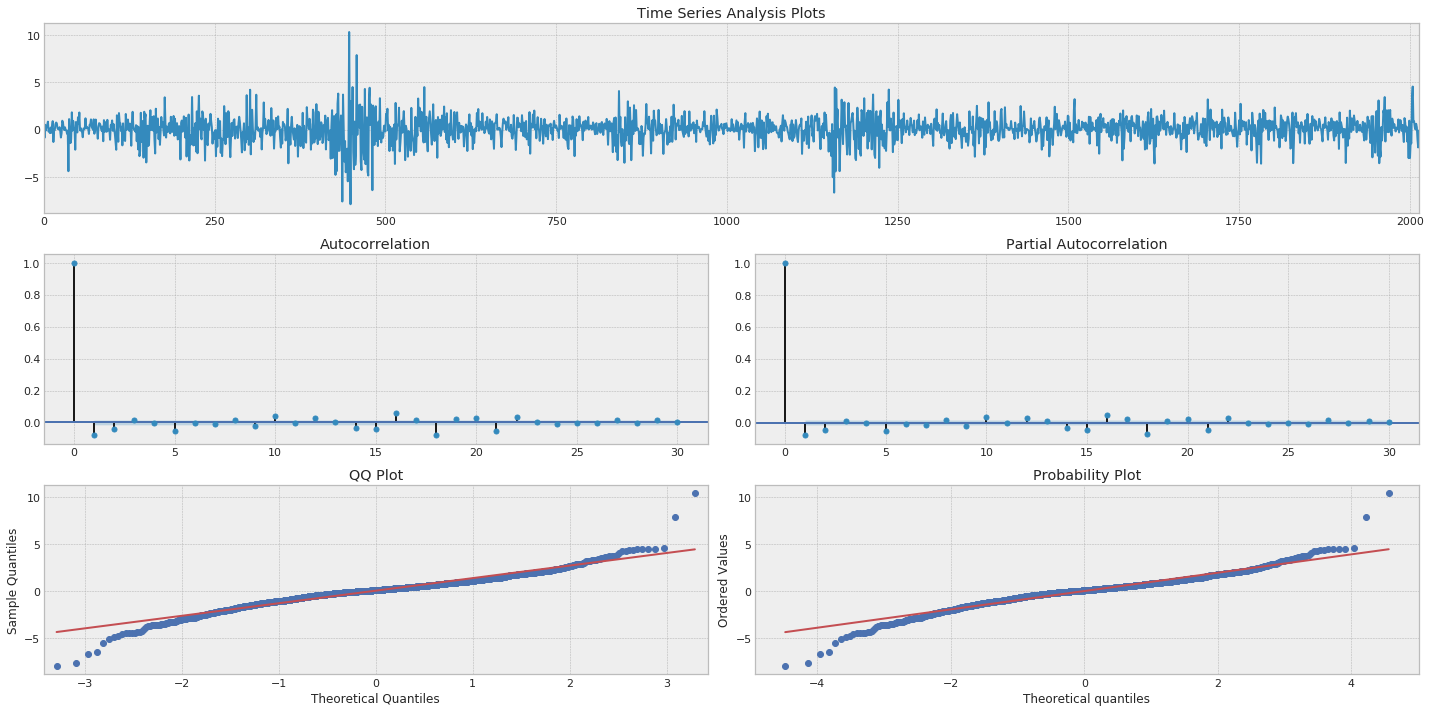

In [50]:
_ = tsplot(np.diff(data.SPY), lags=30)

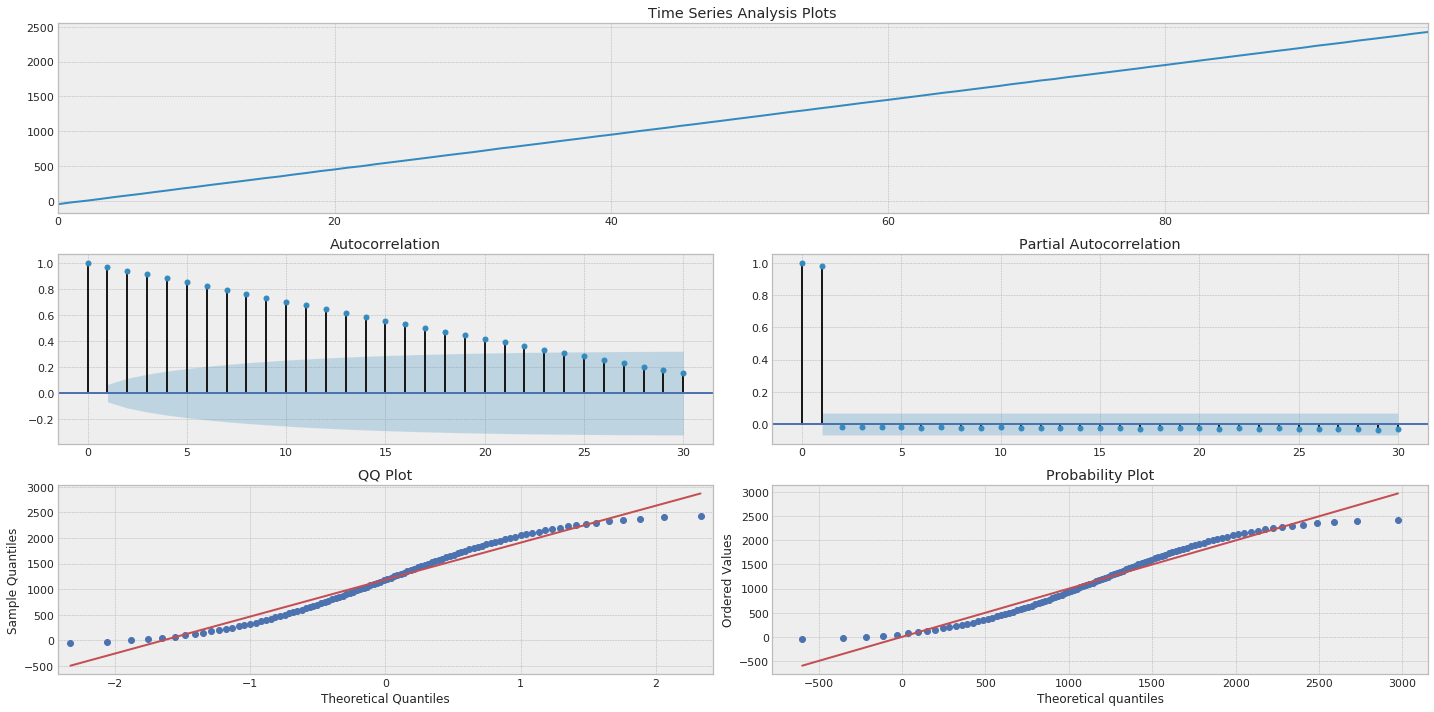

In [52]:
w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=30)  

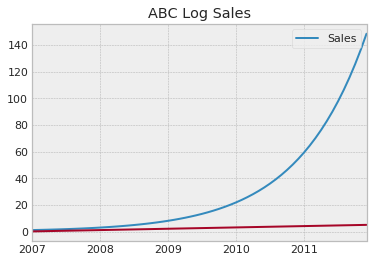

In [54]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')
    
with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('ABC Log Sales')

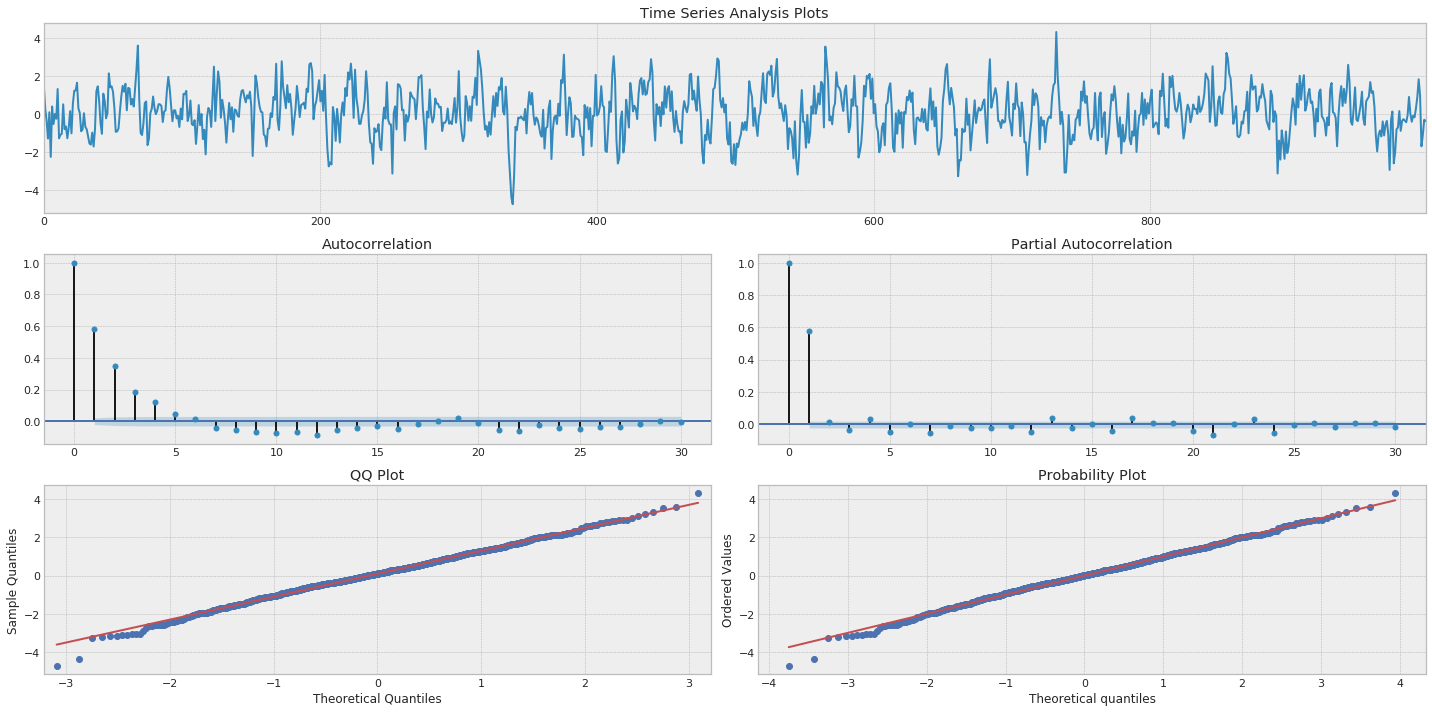

In [56]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

In [ ]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%timeit est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')
print(f'alpha estimate: {mdl.params[0]:3.5f} | best lag order = {est_order}')
print(f'true alpha = {a} | true order = {1}')


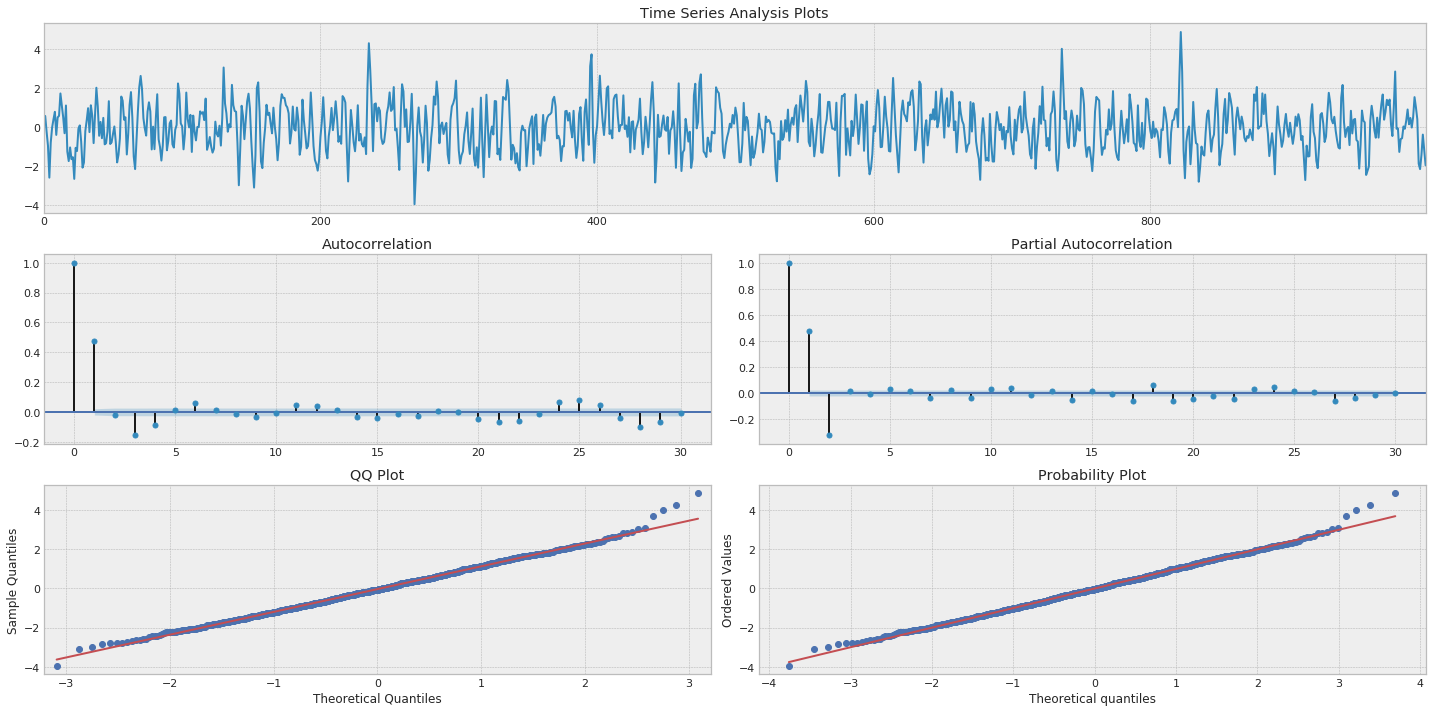

In [62]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

In [63]:
max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
%timeit est_order = smt.AR(ar2).select_order(maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print(f'coef estimate: {mdl.params[0]:3.4f} {mdl.params[1]:3.4f} | best lag order = {est_order}')
print(f'true coefs = {alphas} | true order = {2}')

820 ms ± 60.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
coef estimate: 0.6291 -0.3196 | best lag order = 1
true coefs = [ 0.666 -0.333] | true order = 2


In [64]:
max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
%timeit est_order = smt.AR(lrets.MSFT).select_order(maxlag=max_lag, ic='aic', trend='nc')
print(f'best estimated lag order = {est_order}')

/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 23


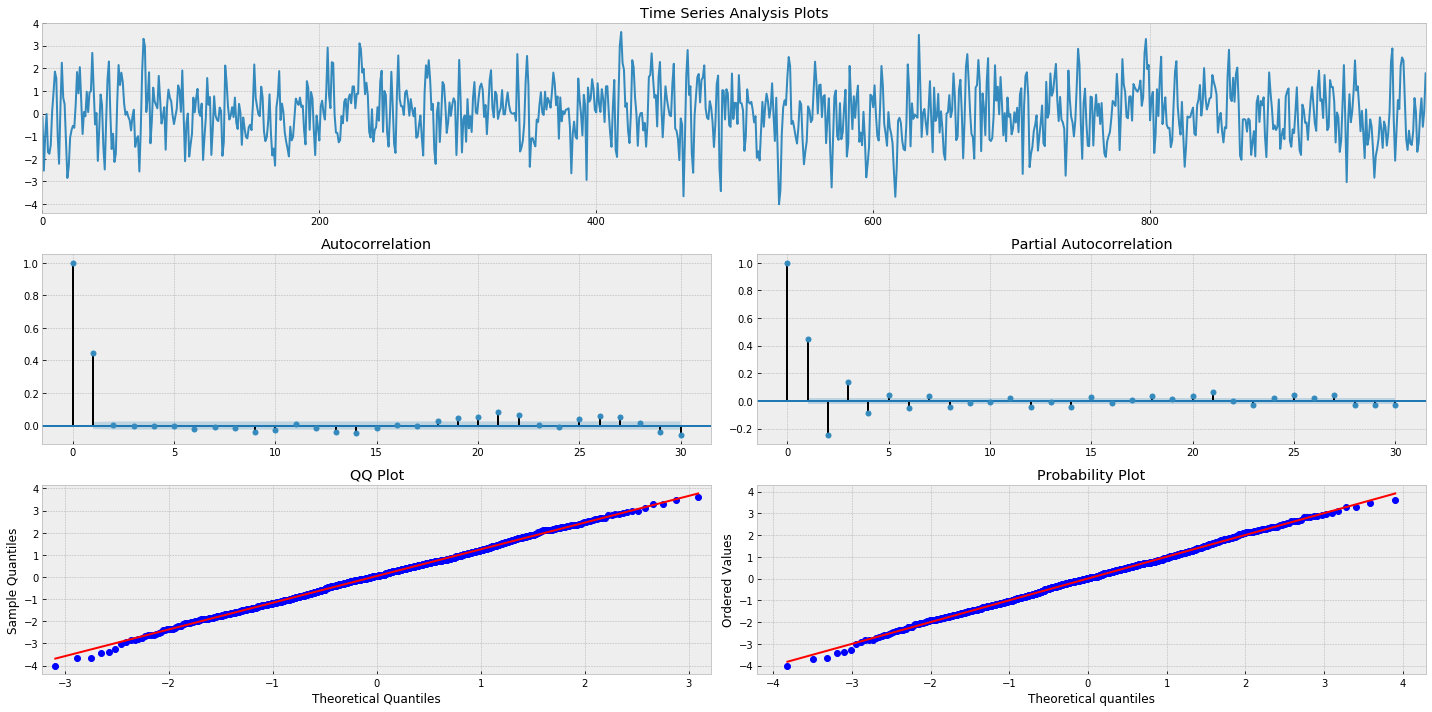

In [6]:
selc

In [7]:
max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1448.721
Method:                           mle   S.D. of innovations              1.030
Date:                Sun, 05 May 2019   AIC                           2901.441
Time:                        18:26:05   BIC                           2911.257
Sample:                             0   HQIC                          2905.172
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6158      0.026     23.947      0.000       0.565       0.666
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.6240           +0.0000j            1.6240            0.5000
-----------------------------------------------------------------------------
"""

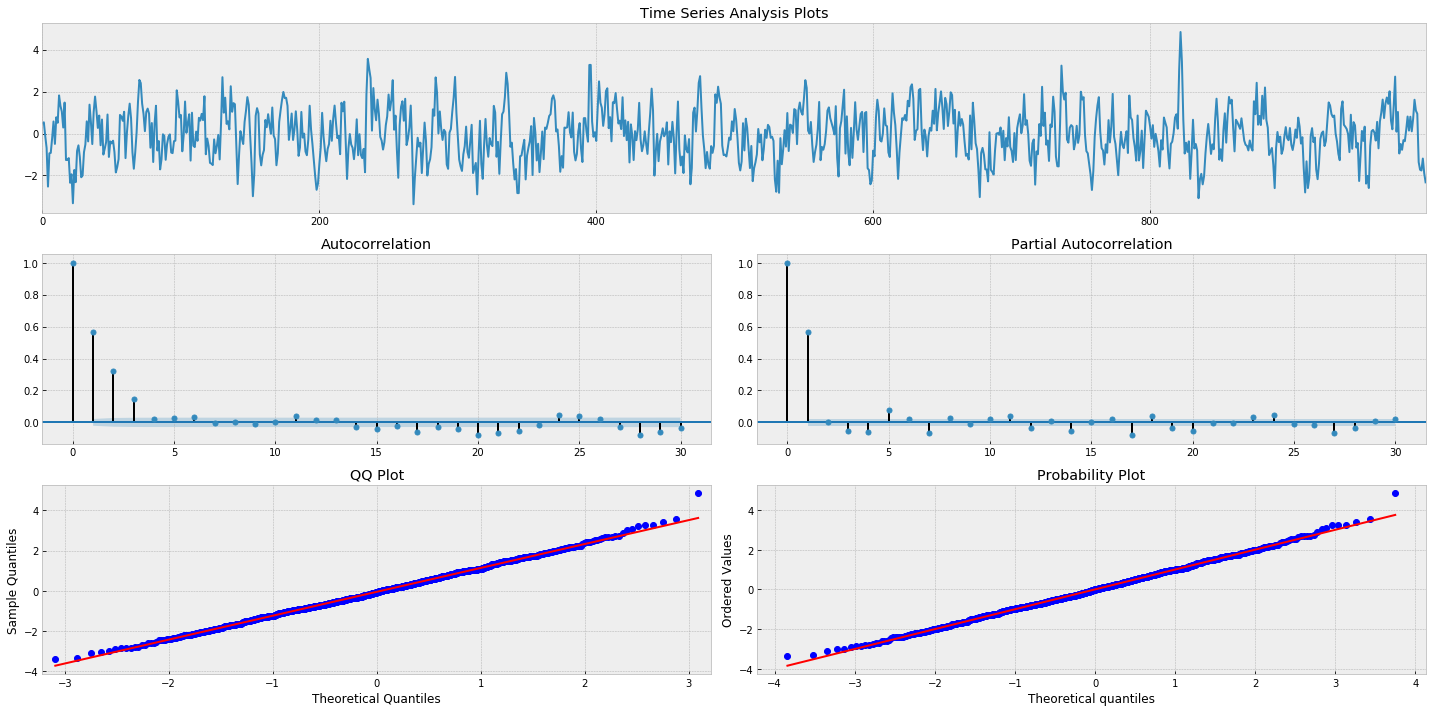

In [8]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [11]:
max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1389.808
Method:                           mle   S.D. of innovations              0.971
Date:                Sun, 05 May 2019   AIC                           2787.616
Time:                        18:30:26   BIC                           2807.247
Sample:                             0   HQIC                          2795.077
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5673      0.031     18.393      0.000       0.507       0.628
ma.L2.y        0.3662      0.034     10.621      0.000       0.299       0.434
ma.L3.y        0.1966      0.030      6.539      0.000       0.138       0.255
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.0234           -1.6735j            1.6736           -0.2522
MA.2           -0.0234           +1.6735j            1.6736            0.2522
MA.3           -1.8162           -0.0000j            1.8162           -0.5000
-----------------------------------------------------------------------------
"""

/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2014
Model:                     ARMA(0, 3)   Log Likelihood                5760.302
Method:                           mle   S.D. of innovations              0.014
Date:                Sun, 05 May 2019   AIC                         -11512.604
Time:                        18:31:23   BIC                         -11490.173
Sample:                             0   HQIC                        -11504.371
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0958      0.022     -4.313      0.000      -0.139      -0.052
ma.L2.SPY     -0.0736      0.023     -3.256      0.001      -0.118      -0.029
ma.L3.SPY      0.0274      0.022      1.259      0.2

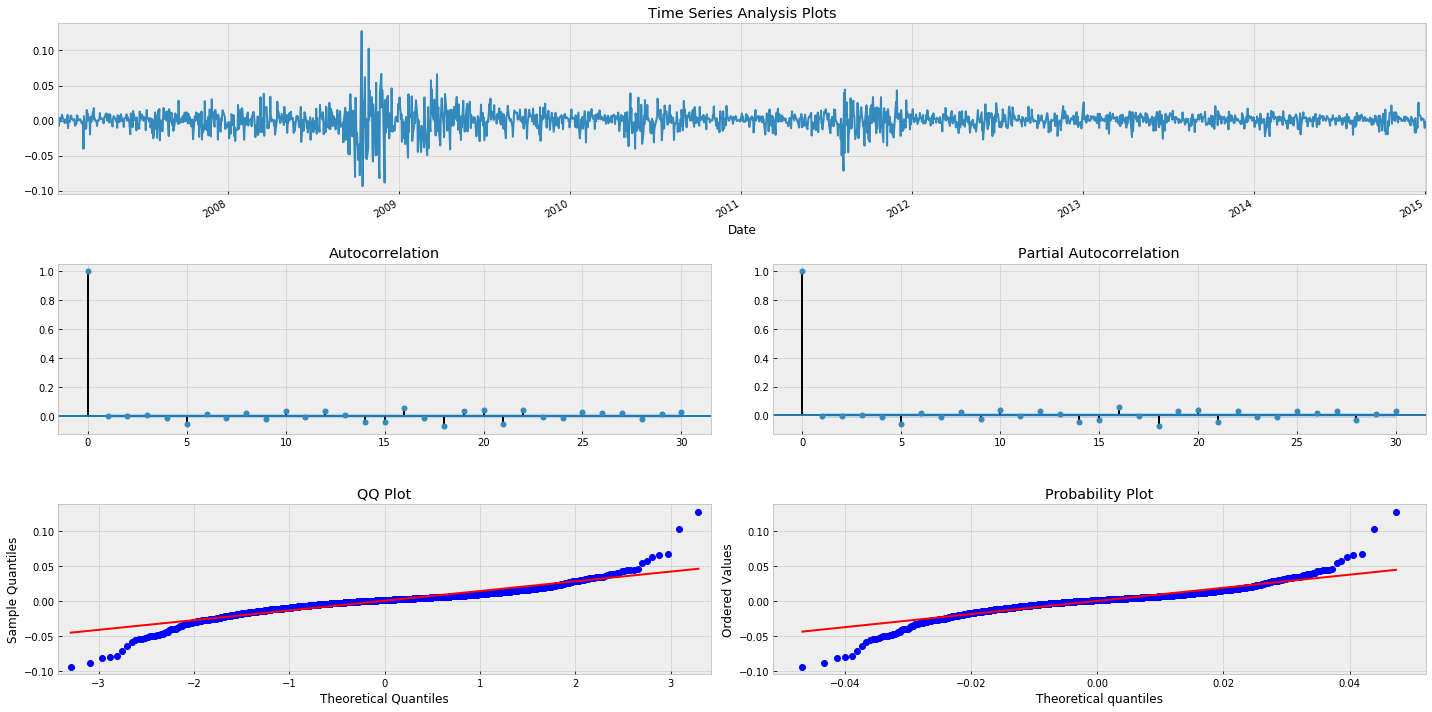

In [13]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7104.237
Method:                           mle   S.D. of innovations              1.002
Date:                Sun, 05 May 2019   AIC                          14218.474
Time:                        18:33:46   BIC                          14251.060
Sample:                             0   HQIC                         14229.895
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4849      0.049      9.905      0.000       0.389       0.581
ar.L2.y       -0.2647      0.015    -17.493      0.000      -0.294      -0.235
ma.L1.y        0.4990      0.050      9.988      0.000       0.401       0.597
ma.L2.y       -0.2832      0.046     -6.210      0.000      -0.373      -0.194
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9159           -1.7142j            1.9436           -0.1719
AR.2            0.9159           +1.7142j            1.9436            0.1719
MA.1           -1.1944           +0.0000j            1.1944            0.5000
MA.2            2.9567           +0.0000j            2.9567            0.0000
-----------------------------------------------------------------------------
"""

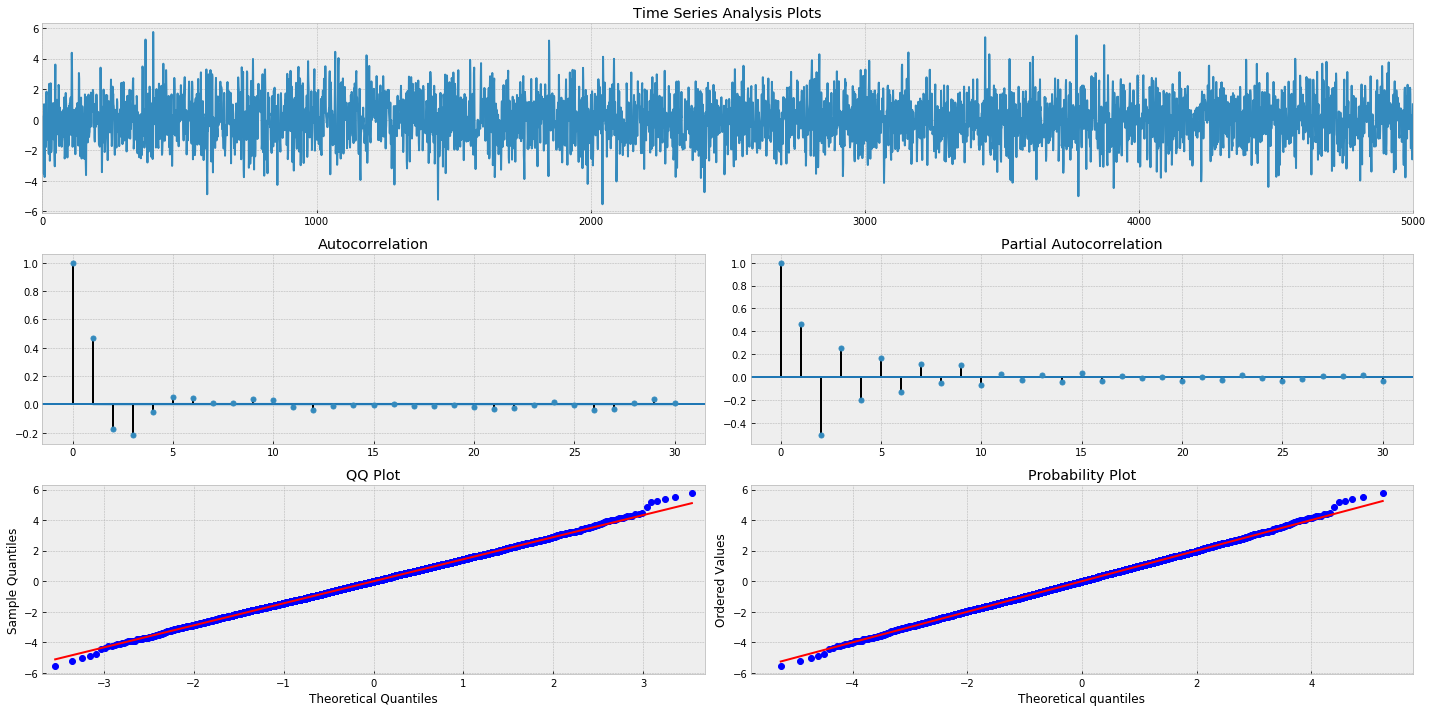

In [14]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
mdl.summary()

aic: 14051.72584 | order: (4, 4)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(4, 4)   Log Likelihood               -7016.863
Method:                           mle   S.D. of innovations              0.984
Date:                Sun, 05 May 2019   AIC                          14051.726
Time:                        18:40:58   BIC                          14110.381
Sample:                             0   HQIC                         14072.283
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y       -0.3570      0.045     -7.945      0.000      -0.445      -0.269
ar.L2.y        0.2350      0.035      6.652      0.000       0.166       0.304
ar.L3.y        0.08

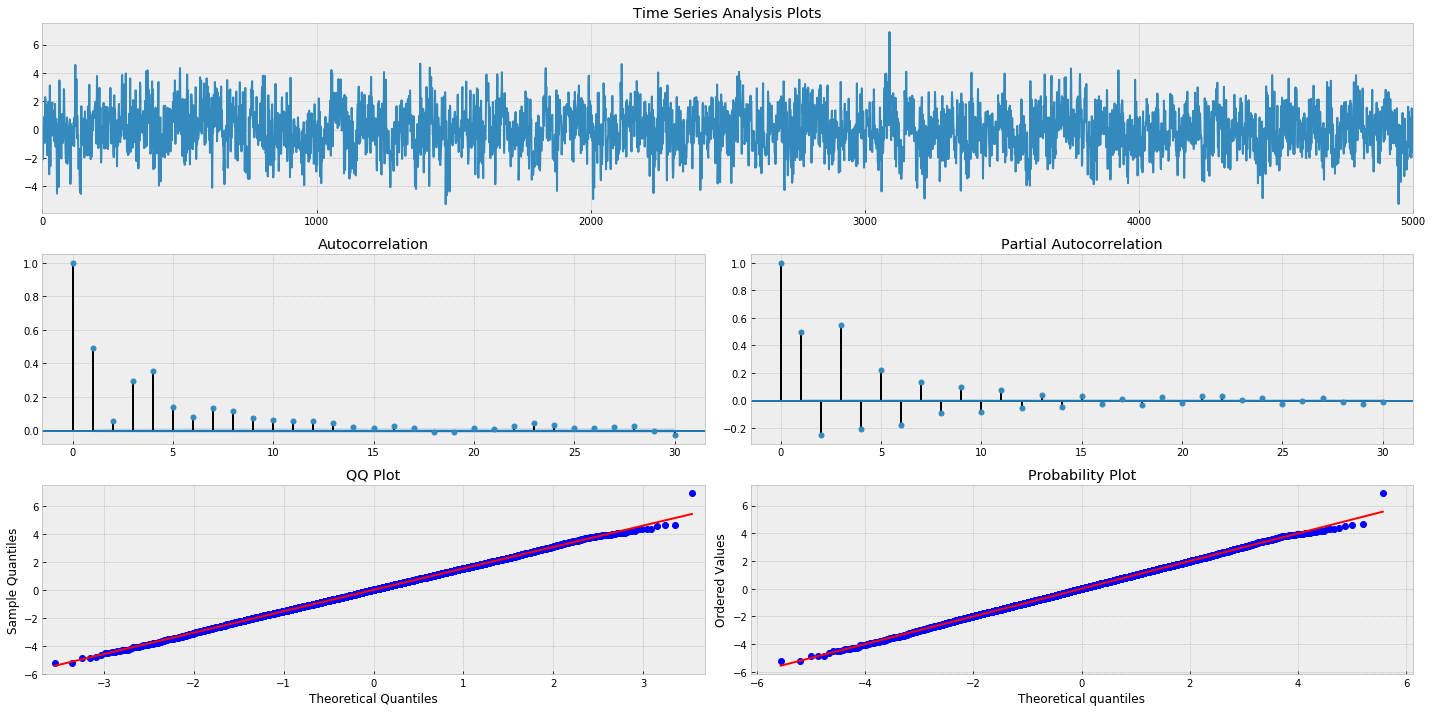

In [17]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 1000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print(f'aic: {best_aic:6.5f} | order: {best_order}')
print(best_mdl.summary())

In [18]:
# Fit ARMA model to SPY returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print(f'aic: {best_aic:6.5f} | order: {best_order}')
print(best_mdl.summary())

/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated fre

aic: -11527.18468 | order: (4, 3)
                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2014
Model:                     ARMA(4, 3)   Log Likelihood                5771.592
Method:                           mle   S.D. of innovations              0.014
Date:                Sun, 05 May 2019   AIC                         -11527.185
Time:                        18:41:38   BIC                         -11482.322
Sample:                             0   HQIC                        -11510.718
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.SPY     -0.6734      0.617     -1.091      0.276      -1.884       0.537
ar.L2.SPY     -0.9993      0.510     -1.958      0.050      -2.000       0.001
ar.L3.SPY      0.0

/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2014
Model:                     ARMA(4, 3)   Log Likelihood                5771.592
Method:                           mle   S.D. of innovations              0.014
Date:                Sun, 05 May 2019   AIC                         -11527.185
Time:                        18:42:47   BIC                         -11482.322
Sample:                             0   HQIC                        -11510.718
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.SPY     -0.6734      0.617     -1.091      0.276      -1.884       0.537
ar.L2.SPY     -0.9993      0.510     -1.958      0.050      -2.000       0.001
ar.L3.SPY      0.0119      0.650      0.018      0.9

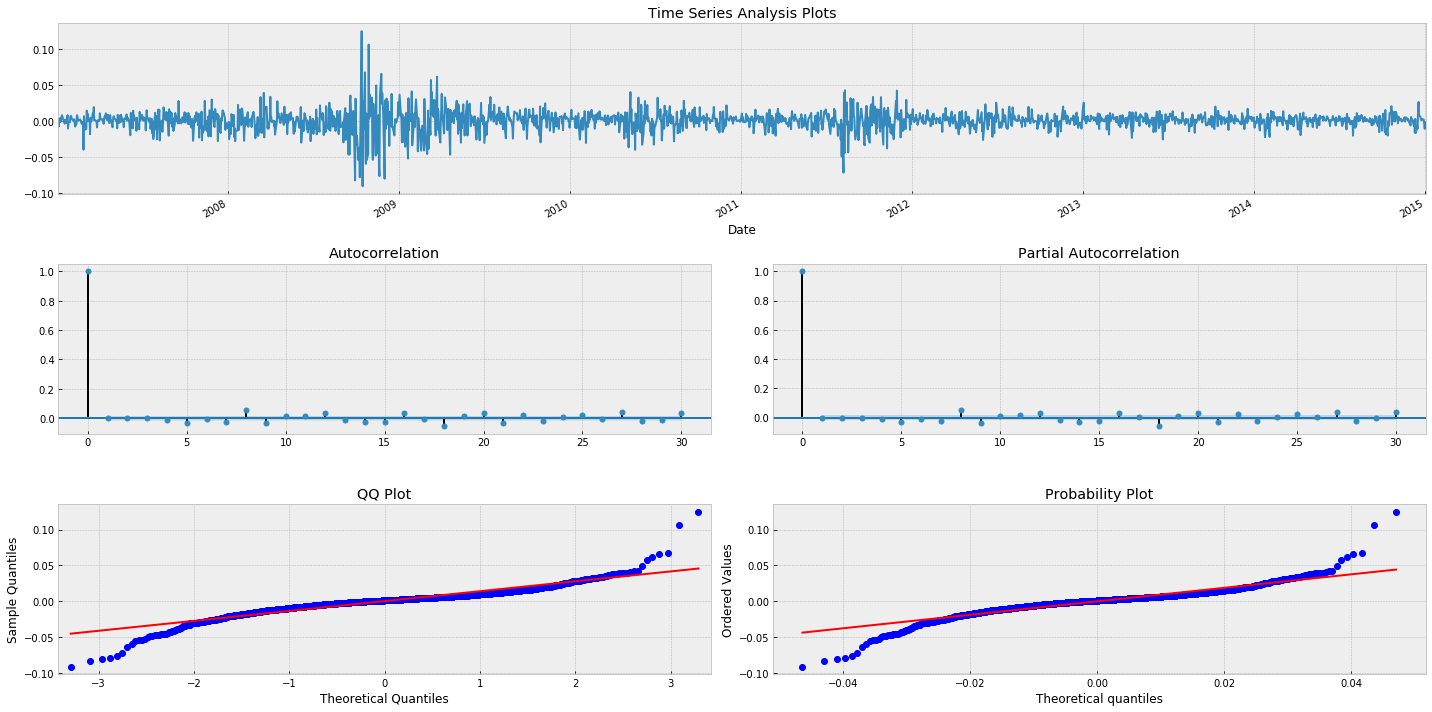

In [19]:
max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(4, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

In [47]:
lrets

,SPY,TLT,MSFT
Date,,,
2007-01-04,0.002120,0.006045,-0.001676
2007-01-05,-0.008008,-0.004362,-0.005719
2007-01-08,0.004614,0.001792,0.009736
2007-01-09,-0.000850,0.000000,0.001002
2007-01-10,0.003326,-0.004486,-0.010064
2007-01-11,0.004371,-0.005860,0.034464
2007-01-12,0.007568,-0.004647,0.016476
2007-01-16,-0.001957,0.002156,-0.001603
2007-01-17,0.000419,-0.003065,-0.001928


/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated fre

/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated fre

/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/diogo/anaconda3/lib/python3.7/

aic: -11527.18468 | order: (4, 0, 3)


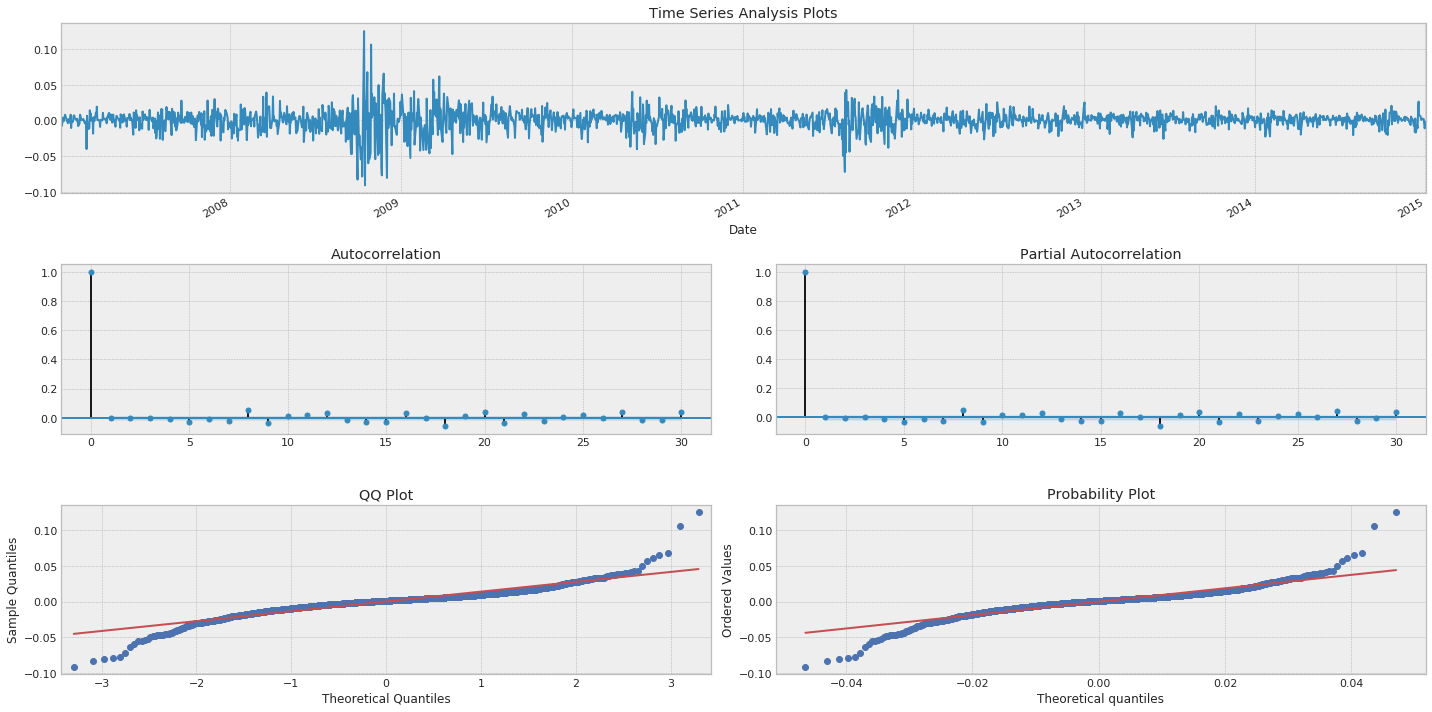

In [40]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [41]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2015-01-02,0.000108,-0.026895,-0.035379,0.027110,0.035595
2015-01-03,0.000356,-0.026761,-0.035282,0.027474,0.035995
2015-01-04,0.000410,-0.026766,-0.035306,0.027587,0.036126
2015-01-05,-0.000603,-0.027786,-0.036328,0.026580,0.035122
2015-01-06,-0.000006,-0.027189,-0.035731,0.027178,0.035719


DatetimeIndex(['2013-01-09', '2013-01-10', '2013-01-11', '2013-01-14',
               '2013-01-15', '2013-01-16', '2013-01-17', '2013-01-18',
               '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25',
               '2013-01-28', '2013-01-29', '2013-01-30', '2013-01-31',
               '2013-02-01', '2013-02-04', '2013-02-05', '2013-02-06',
               '2013-02-07', '2013-02-08', '2013-02-11', '2013-02-12',
               '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-19',
               '2013-02-20', '2013-02-21', '2013-02-22', '2013-02-25',
               '2013-02-26', '2013-02-27', '2013-02-28', '2013-03-01',
               '2013-03-04', '2013-03-05', '2013-03-06', '2013-03-07',
               '2013-03-08', '2013-03-11', '2013-03-12', '2013-03-13',
               '2013-03-14', '2013-03-15', '2013-03-18', '2013-03-19',
               '2013-03-20', '2013-03-21'],
              dtype='datetime64[ns]', name='Date', freq=None) 2013-01-09 00:00:00 2015-01-02 00:00:00


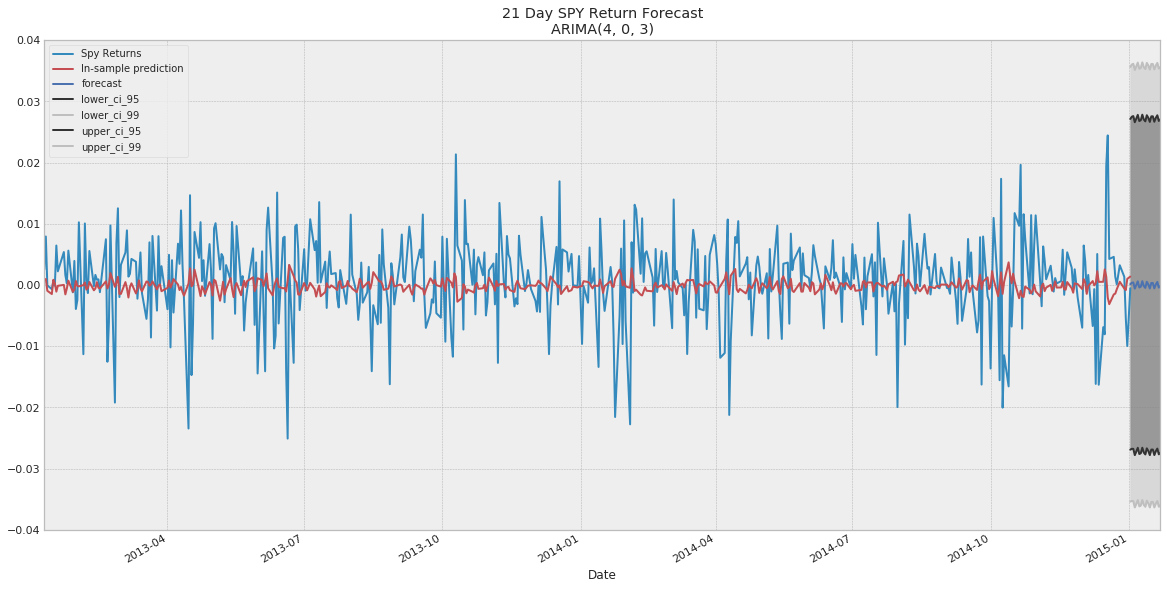

In [72]:
plt.style.use('bmh')
fig = plt.figure(figsize=(20,10))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
reference = 450
#print()
print(lrets.SPY.index[-(reference + 50):-reference], ts.index[0], ts.index[-1])
#pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred = best_mdl.predict(len(data)-500)
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

In [57]:
lrets.iloc[0], lrets.iloc[-1]

(SPY     0.002120
 TLT     0.006045
 MSFT   -0.001676
 Name: 2007-01-04 00:00:00, dtype: float64, SPY    -0.000535
 TLT     0.011057
 MSFT    0.006652
 Name: 2015-01-02 00:00:00, dtype: float64)

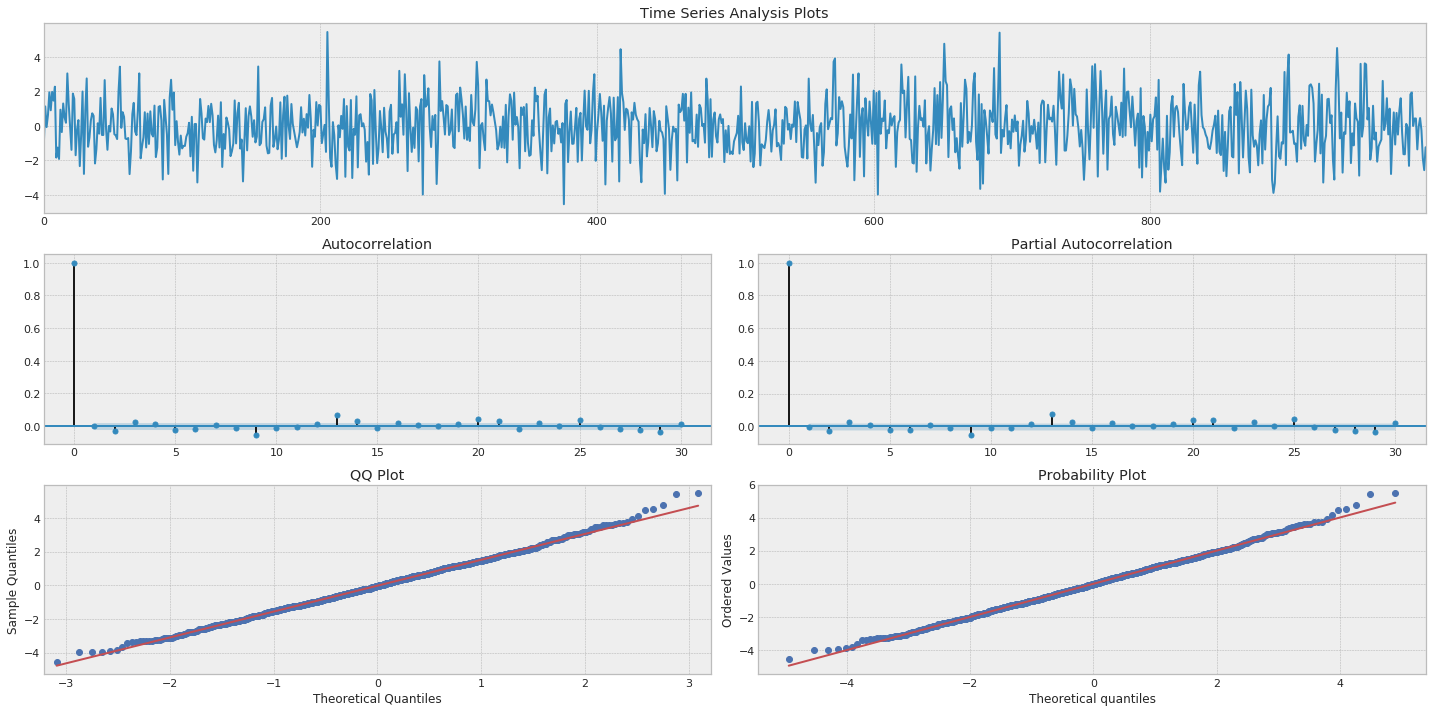

In [73]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

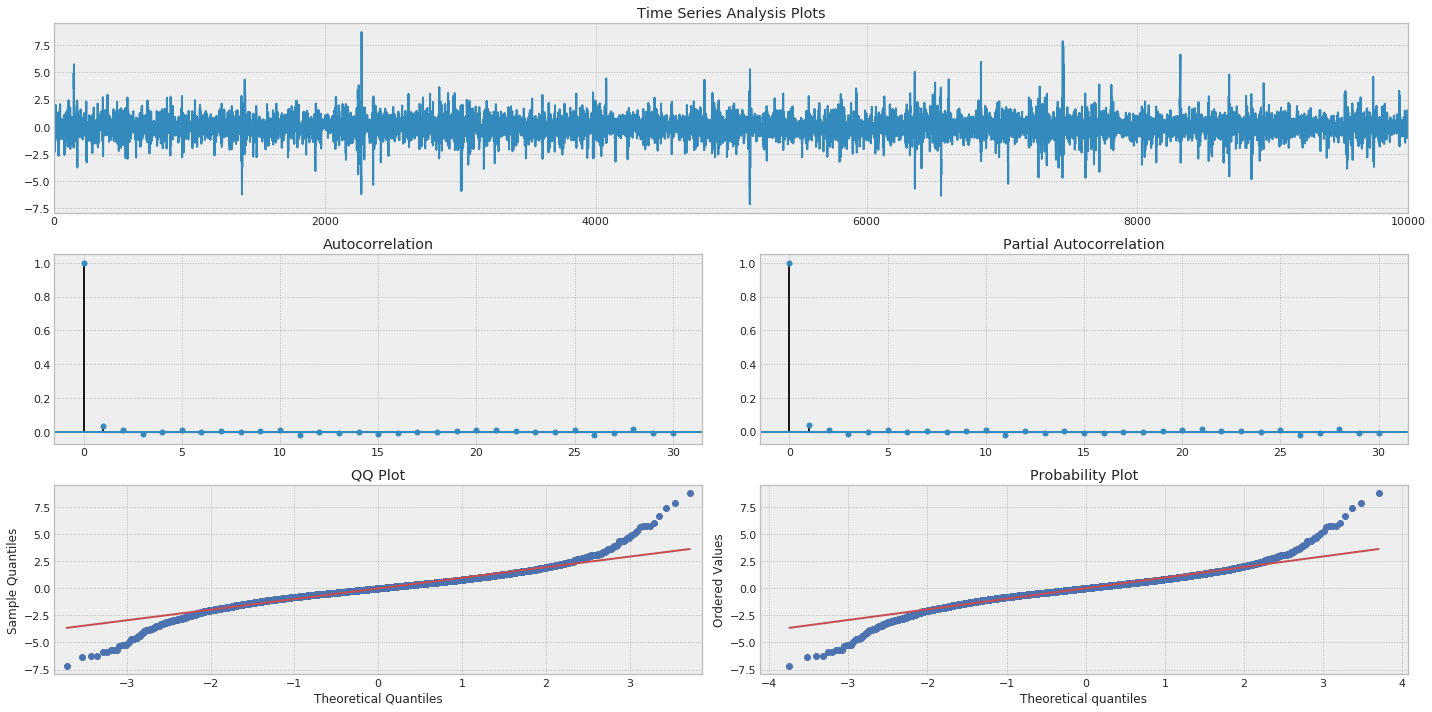

In [74]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

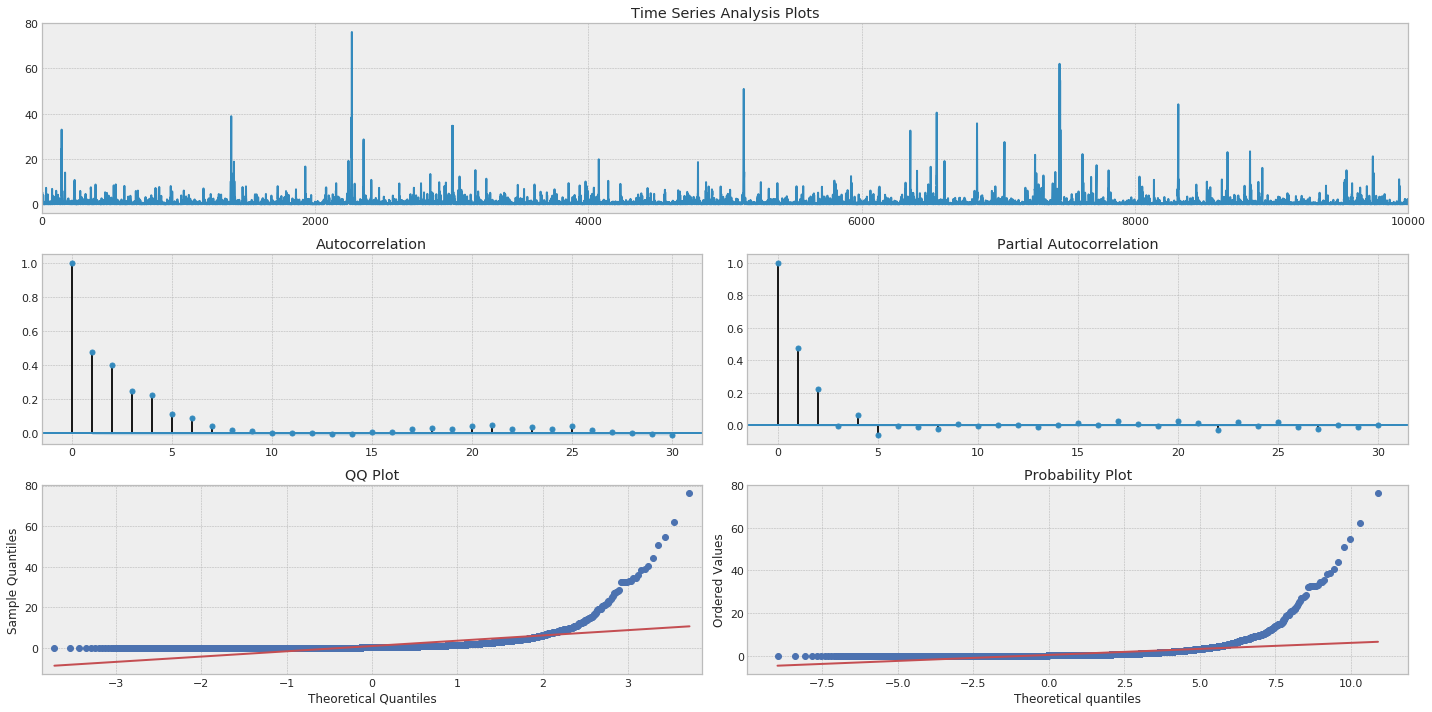

In [75]:
_ = tsplot(eps**2, lags=30)

In [77]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
res.summary()

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592658753043
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.30326731947
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Sun, May 05 2019   Df Residuals:                     9996
Time:                        19:41:52   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.7225e-03  6.735e-03     -0.998      0.318 [-1.992e-02,6.478e-03]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.2021  1.043e-02     19.383  1.084e-83 [  0.182,  0.223]
alpha[1]       0.5162  2.016e-02     25.611 1.144e-144 [  0.477,  0.556]
beta[1]        0.2879  1.870e-02     15.395  1.781e-53 [  0.251,  0.325]
========================================================================

Covariance estimator: robust
"""

In [79]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.SPY.ix['2012':'2015']
res_tup = _get_best_model(TS)

/home/diogo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but i

/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated fre

/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/diogo/anaconda3/lib

aic: -5263.47204 | order: (3, 0, 2)


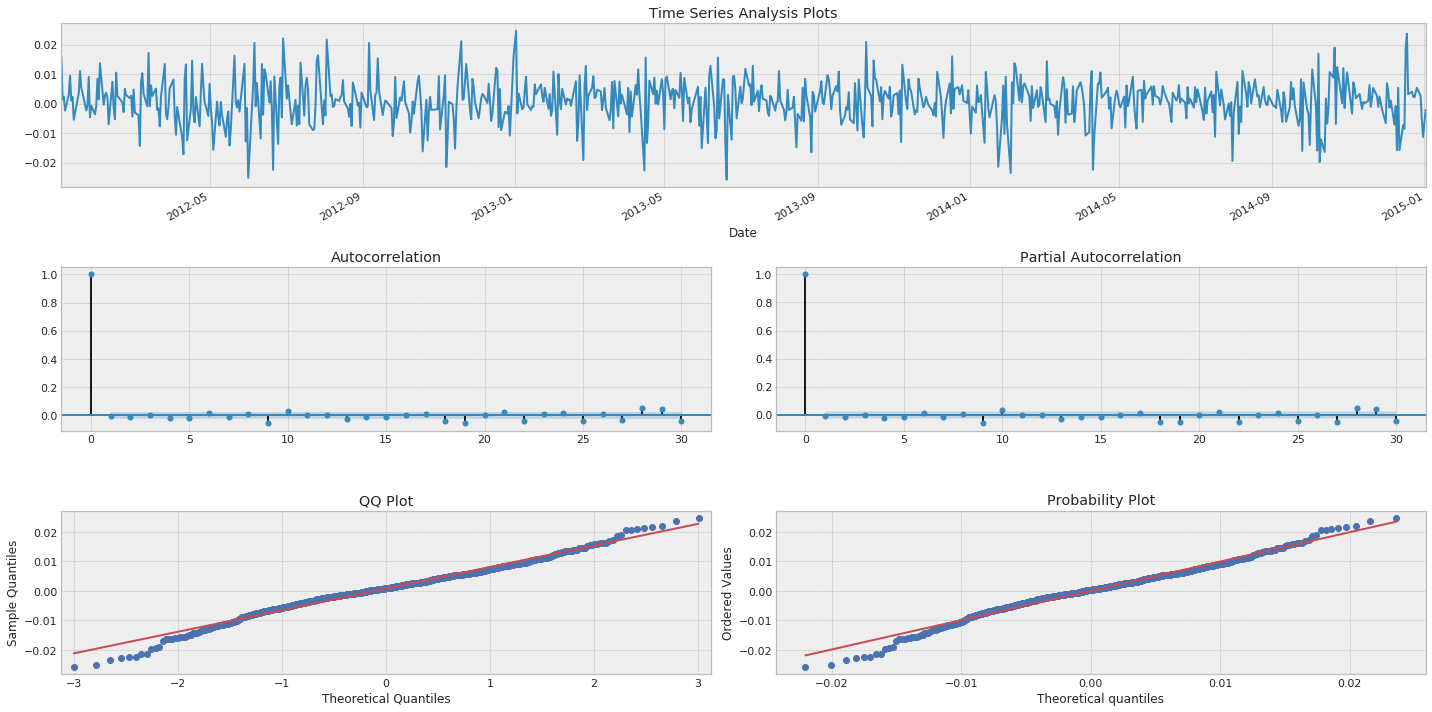

In [80]:
_ = tsplot(res_tup[-1].resid, lags=30)

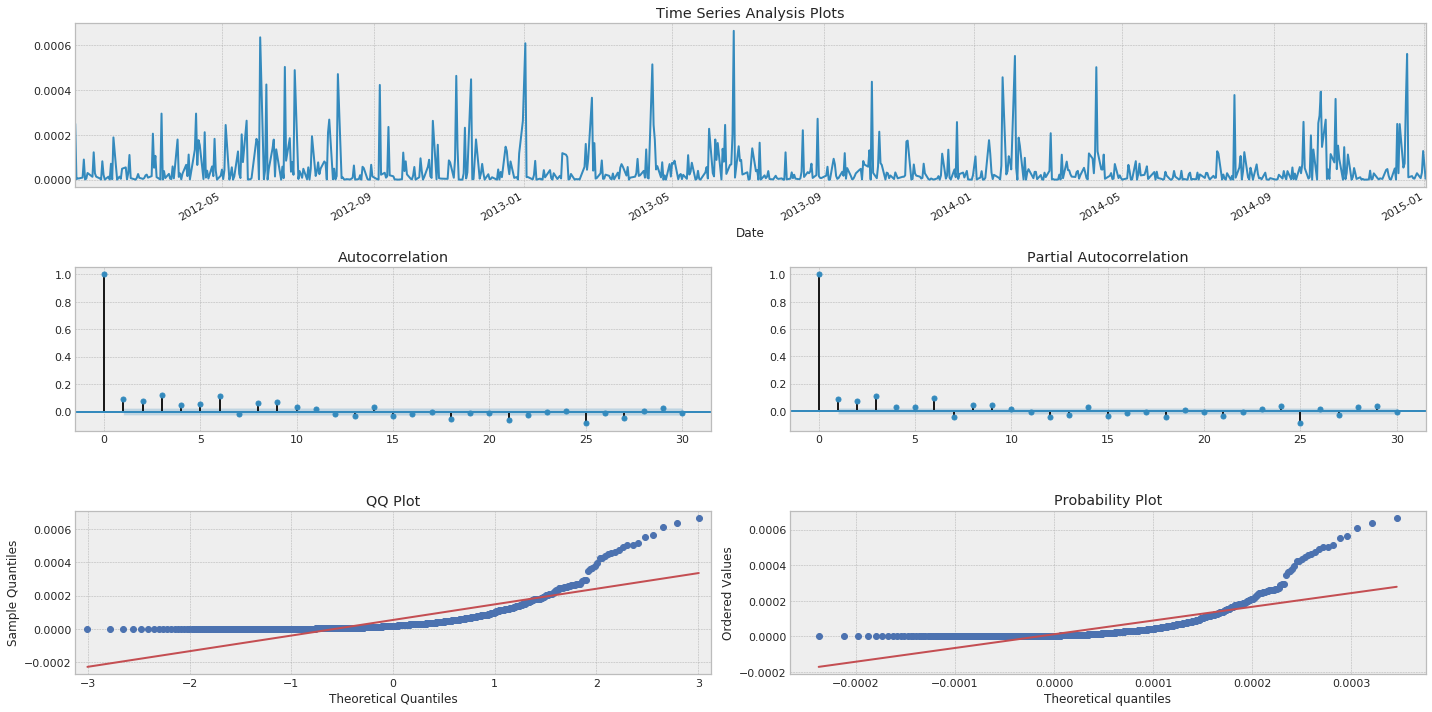

In [81]:
_ = tsplot(res_tup[-1].resid**2, lags=30)

In [85]:
# Now we can fit the arch model using the best fit arima model parameters

_, order, _ = res_tup
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
res.summary()

/home/diogo/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                          SPY   R-squared:                -1512121.748
Mean Model:                   Constant Mean   Adj. R-squared:           -1512121.748
Vol Model:                            GARCH   Log-Likelihood:               -3024.24
Distribution:      Standardized Student's t   AIC:                           6064.48
Method:                  Maximum Likelihood   BIC:                           6101.49
                                              No. Observations:                  755
Date:                      Sun, May 05 2019   Df Residuals:                      747
Time:                              19:50:10   Df Model:                            8
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -9.0502      0.908     -9.971  2.046e-23 [-10.829, -7.271]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.2125e-06  8.380e-05  9.800e-02      0.922 [-1.560e-04,1.725e-04]
alpha[1]       0.7266      0.858      0.846      0.397      [ -0.956,  2.409]
alpha[2]   1.3531e-04      1.253  1.080e-04      1.000      [ -2.456,  2.457]
alpha[3]   2.7210e-05      0.815  3.339e-05      1.000      [ -1.597,  1.597]
beta[1]        0.1555      1.500      0.104      0.917      [ -2.785,  3.096]
beta[2]        0.1189      0.486      0.245      0.807      [ -0.833,  1.071]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
nu            26.2796     74.324      0.354      0.724 [-1.194e+02,1.720e+02]
=============================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Positive directional derivative for linesearch. See convergence_flag.
"""

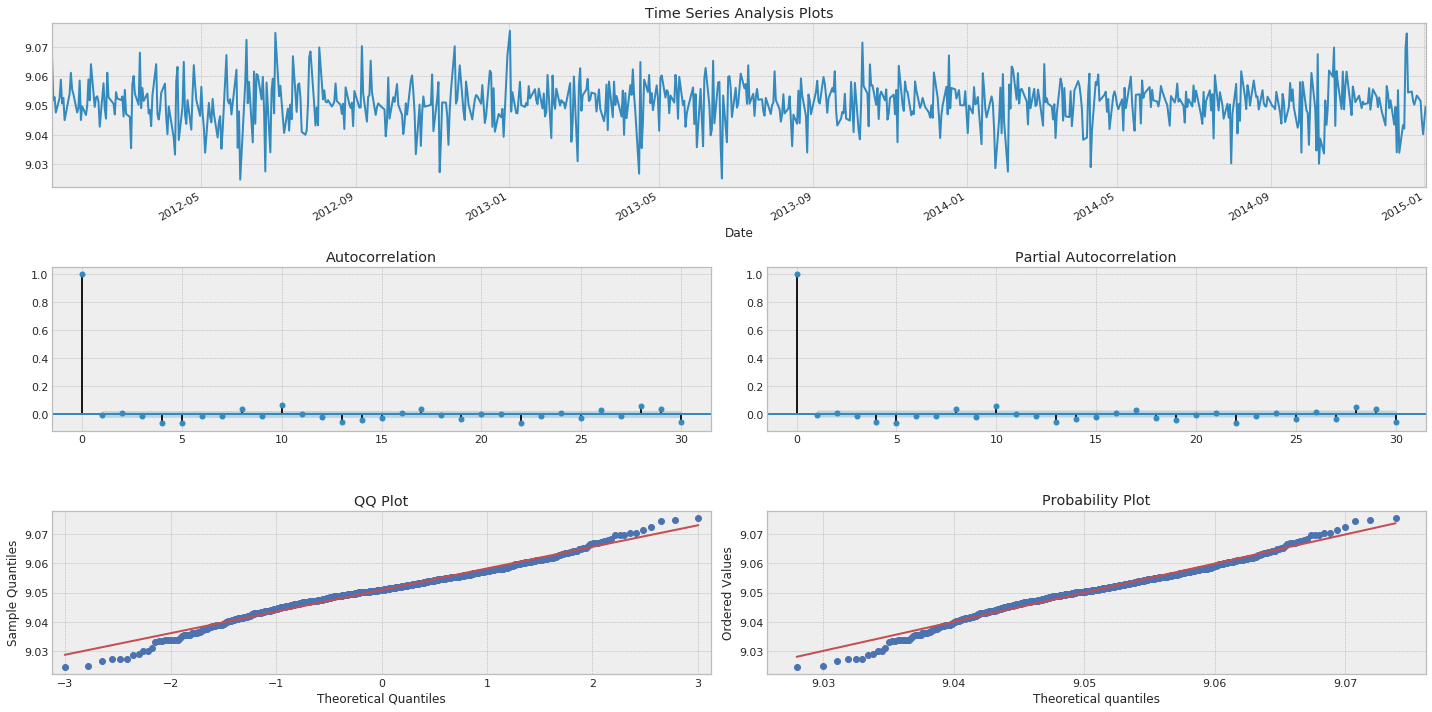

In [86]:
_ = tsplot(res.resid, lags=30)

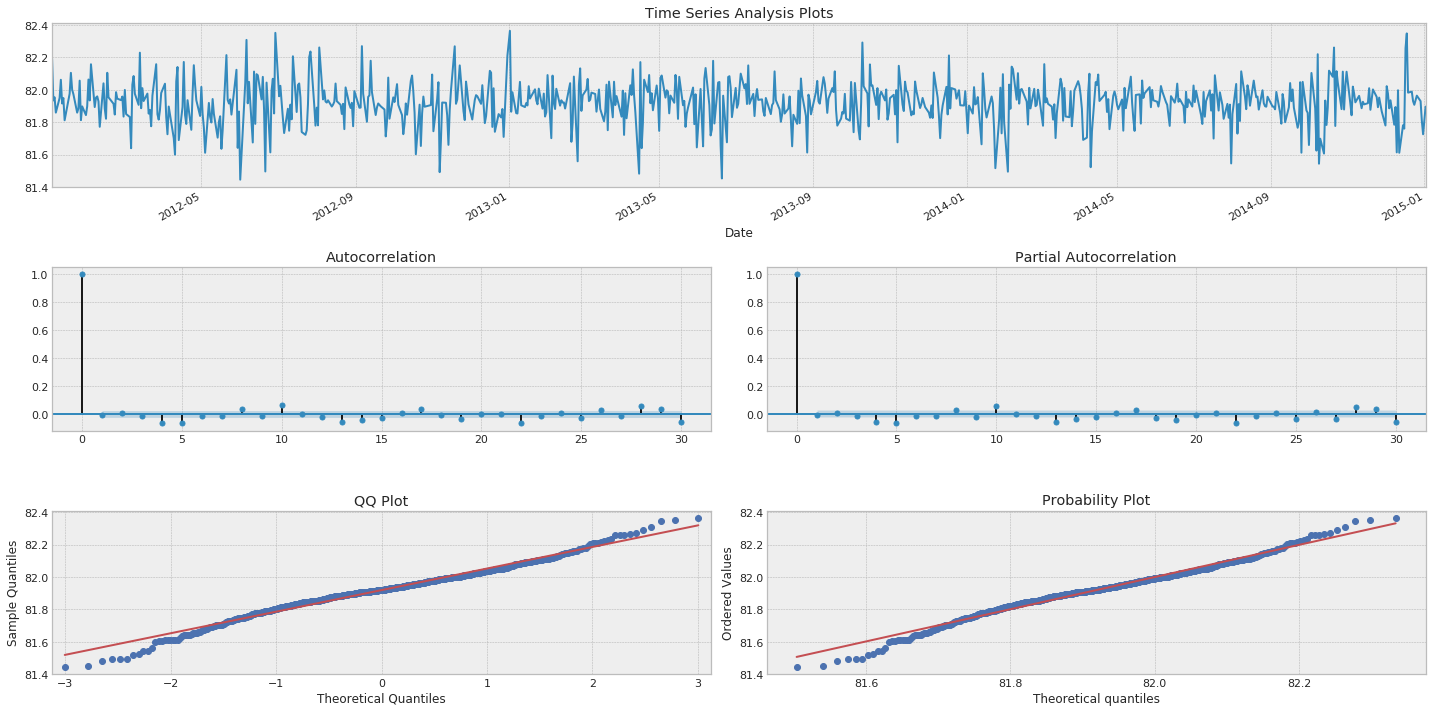

In [87]:
_ = tsplot(res.resid**2, lags=30)

In [90]:
res

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                -1512121.748
Mean Model:                   Constant Mean   Adj. R-squared:           -1512121.748
Vol Model:                            GARCH   Log-Likelihood:               -3024.24
Distribution:      Standardized Student's t   AIC:                           6064.48
Method:                  Maximum Likelihood   BIC:                           6101.49
                                              No. Observations:                  755
Date:                      Sun, May 05 2019   Df Residuals:                      747
Time:                              19:50:10   Df Model:                            8
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -9

In [91]:
#****************************************************************************************
#* https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html *
#****************************************************************************************

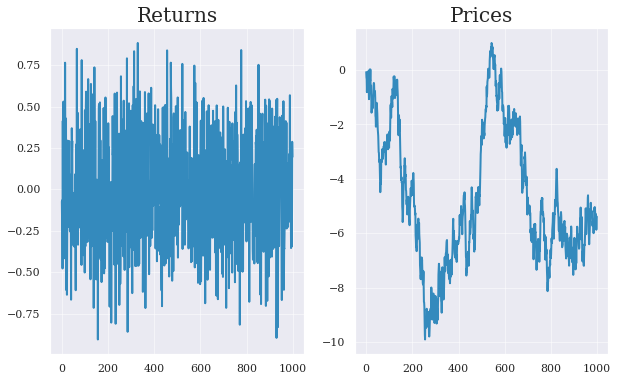

In [93]:
import numpy as np
import matplotlib.pyplot as plt


def garch(ω, α, β, n_out=1000):
    p = len(α)
    q = len(β)

    # Since the first max(p, q) number of points are not generated from the garch
    # process, the first points are garbage (possibly extending beyond max(p, q)),
    # so we drop n_pre > max(p, q) number of points.
    n_pre = 1000
    n = n_pre + n_out

    # Sample noise
    ɛ = np.random.normal(0, 1, n)

    y = np.zeros(n)
    σ = np.zeros(n)

    # Pre-populate first max(p, q) values, because they are needed in the iteration.
    for k in range(np.max([p, q])):
        σ[k] = np.random.normal(0, 1)
        y[k] = σ[k] * ɛ[k]

    # Run the garch process, notation from
    # http://stats.lse.ac.uk/fryzlewicz/lec_notes/garch.pdf
    for k in range(np.max([p, q]), n):
        α_term = sum([α[i] * y[k-i]**2 for i in range(p)])
        β_term = sum([β[i] * σ[k-i]**2 for i in range(q)])
        σ[k] = np.sqrt(ω + α_term + β_term)
        y[k] = σ[k] * ɛ[k]

    return y[n_pre:]


# Make a cumulative series from a "delta series".
def delta_to_cum(ys):
    ys_cum = []
    y_cum = 0
    for y in ys:
        y_cum += y
        ys_cum.append(y_cum)
    return ys_cum


# Define a garch(1,1) process
ω = 0.1
α = [0.3]
β = [0.2]
y = garch(ω, α, β)
x = range(len(y))

# The resulting series looks like stock returns and
# the cumulative series looks like stock prices.
plt.subplot(1,2,1)
plt.plot(x, y)
plt.title('Returns')
plt.subplot(1,2,2)
plt.plot(x, delta_to_cum(y))
plt.title('Prices')
plt.show()